In [1]:
#Import libraries
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
# Load your data
df = pd.read_csv("./2/dataset_sun_wind.csv")
df = df.dropna()

In [4]:
def parse_time(time_str):
    days, time = time_str.split(' days ')
    hours, minutes, seconds = map(int, time.split(':'))
    return pd.Timedelta(days=int(days), hours=hours, minutes=minutes, seconds=seconds)


df["timedelta"] = df["timedelta"].apply(parse_time)

In [5]:
df = df.sort_values(['period', 'timedelta'])
df['timedelta_seconds'] = df['timedelta'].dt.total_seconds()

In [6]:
df['dst_next'] = df.groupby('period')['dst'].shift(-1)

In [7]:
# 4. Drop rows with NaN in target (last row in each period)
df = df.dropna(subset=['dst_next'])

In [49]:
period_map = {'train_a': 0, 'train_b': 1, 'train_c': 2}
df['period_num'] = df['period'].map(period_map)

In [55]:
# 5. Drop columns we won't use
drop_cols = ['dst_next', 'dst', 'source', 'period', 'timedelta']
X = df.drop(columns=drop_cols)
y = df['dst_next']

In [56]:
y.head()

0   -10.0
1   -10.0
2    -6.0
3    -2.0
4     3.0
Name: dst_next, dtype: float64

In [57]:
# 6. Train-test split (no shuffling to preserve time order)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [66]:
# 7. Train the XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [67]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [68]:
# 8. Evaluate the model
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print(f'Validation RMSE: {rmse:.2f}')

Validation RMSE: 159.27


In [61]:
print(y_pred)

[-13.864429 -11.073104 -12.594709 ... -12.346751 -11.514448 -11.718511]


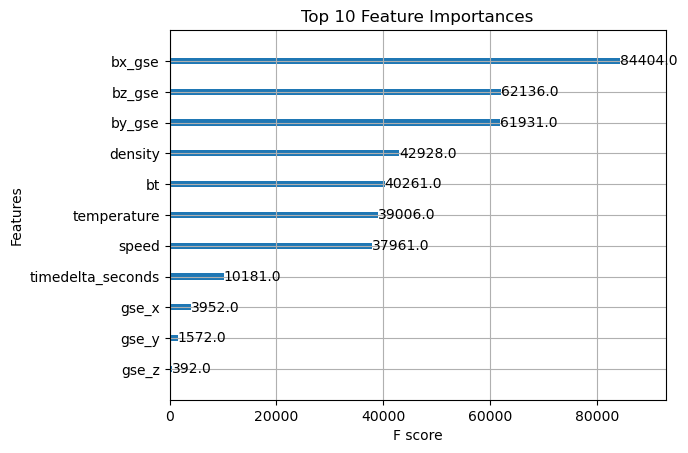

In [62]:
# 9. (Optional) Show feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=20)
plt.title("Top 10 Feature Importances")
plt.show()

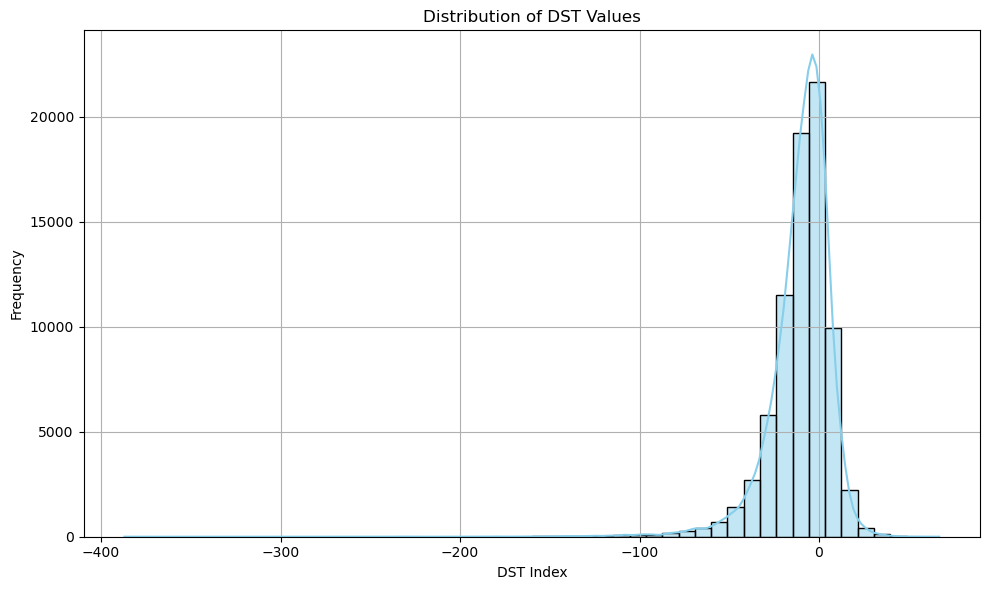

In [17]:
import seaborn as sns


# Optional: convert timedelta if needed
df['timedelta'] = pd.to_timedelta(df['timedelta'])

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['dst'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of DST Values')
plt.xlabel('DST Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()